# Predykcja zainteresowania postami w social media z użyciem metod NLP
### Autor: Jakub Uchman
### Dokładny opis znajduje się w pliku .pdf
---

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.2 MB/s eta 0:00:00


#Trenowanie i zapisanie modelu

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70810
[LightGBM] [Info] Number of data points in the train set: 34681, number of used features: 1004
[LightGBM] [Info] Start training from score 6303.391857
Mean Absolute Error: 3969.9338354531646
R²: 0.4294190409387214


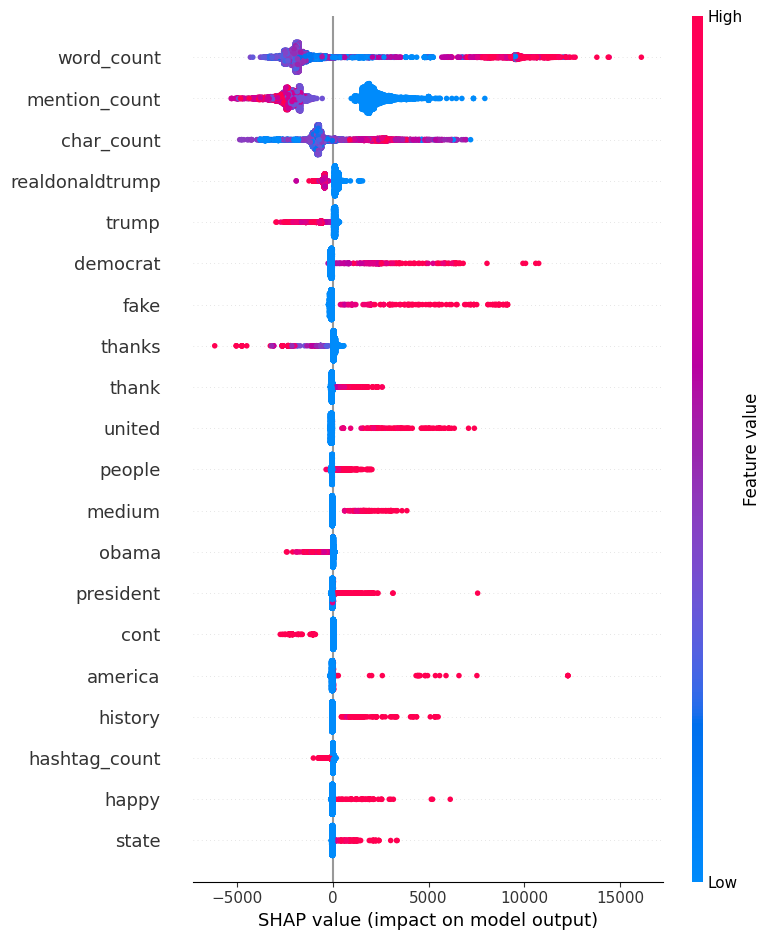

In [2]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import shap
import plotly.express as px
import pickle

# Wczytaj dane
df = pd.read_csv('/content/sample_data/realdonaldtrump.csv')

# Pobierz stopwords i wordnet
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Zamiana na małe litery
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Usunięcie linków
    text = re.sub(r'[^\w\s]', '', text)  # Usunięcie znaków interpunkcyjnych
    text = re.sub(r'\d+', '', text)  # Usunięcie cyfr
    words = text.split()  # Podział na słowa
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lematyzacja i usunięcie stopwords
    return ' '.join(words)

# Wstępne przetwarzanie tekstu
df['clean_text'] = df['content'].apply(preprocess_text)

# Dodatkowe własności
df['char_count'] = df['content'].apply(len)  # Liczba znaków
df['word_count'] = df['content'].apply(lambda x: len(x.split()))  # Liczba słów
df['hashtag_count'] = df['hashtags'].apply(lambda x: len(x.split(",")) if isinstance(x, str) else 0)  # Liczba hashtagów
df['mention_count'] = df['mentions'].apply(lambda x: len(x.split(",")) if isinstance(x, str) else 0)  # Liczba wzmianek

# Wektoryzacja tekstu za pomocą TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df['clean_text']).toarray()
tfidf_feature_names = vectorizer.get_feature_names_out()

# Połączenie cech głównych z dodatkowymi
X_additional = df[['char_count', 'word_count', 'hashtag_count', 'mention_count']].values
X = np.hstack((X_text, X_additional))
all_feature_names = np.concatenate((tfidf_feature_names, ['char_count', 'word_count', 'hashtag_count', 'mention_count']))

# Definiowanie zmiennej docelowej
y = df['retweets'].values

assert X.shape[0] == y.shape[0], "Niezgodność liczby wierszy między cechami a zmienną docelową."

# Podział danych na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trenowanie modelu
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'mae',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'seed': 34
}

model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

# Przewidywanie na zbiorze testowym
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Obliczanie MAE i R2
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R2: {r2}')

# Zapisanie modelu i wektoryzatora
model_filename = 'lightgbm_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

vectorizer_filename = 'tfidf_vectorizer.pkl'
with open(vectorizer_filename, 'wb') as file:
    pickle.dump(vectorizer, file)

# Analiza SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Wykres podsumowujący wartości SHAP
shap.summary_plot(shap_values, X_test, feature_names=all_feature_names)

#INSTRUKCJA WCZYTYWANIA MODELU
#PRZYKŁADOWE WYKORZYSTANIE

# Wczytaj model z pliku
# with open(model_filename, 'rb') as file:
#     loaded_model = pickle.load(file)

# Wczytaj wektoryzator TF-IDF
# with open(vectorizer_filename, 'rb') as file:
#     loaded_vectorizer = pickle.load(file)

# Użyj wczytanego wektoryzatora do przygotwania danych tekstowych
# X_text_loaded = loaded_vectorizer.transform(df['clean_text']).toarray()

# Połącz cechy tekstowe z dodatkowymi cechami
# X_additional_loaded = df[['char_count', 'word_count', 'hashtag_count', 'mention_count']].values
# X_loaded = np.hstack((X_text_loaded, X_additional_loaded))

# Przewiduj za pomocą wczytanego modelu
# y_pred_loaded = loaded_model.predict(X_loaded, num_iteration=loaded_model.best_iteration)


#Wczytanie modelu, sprawdzenie poprawności i wyświetlenie kilku wykresów

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Średni błąd bezwzględny (MAE): 3765.9802704728677
Współczynnik determinacji (R²): 0.5536084256417636


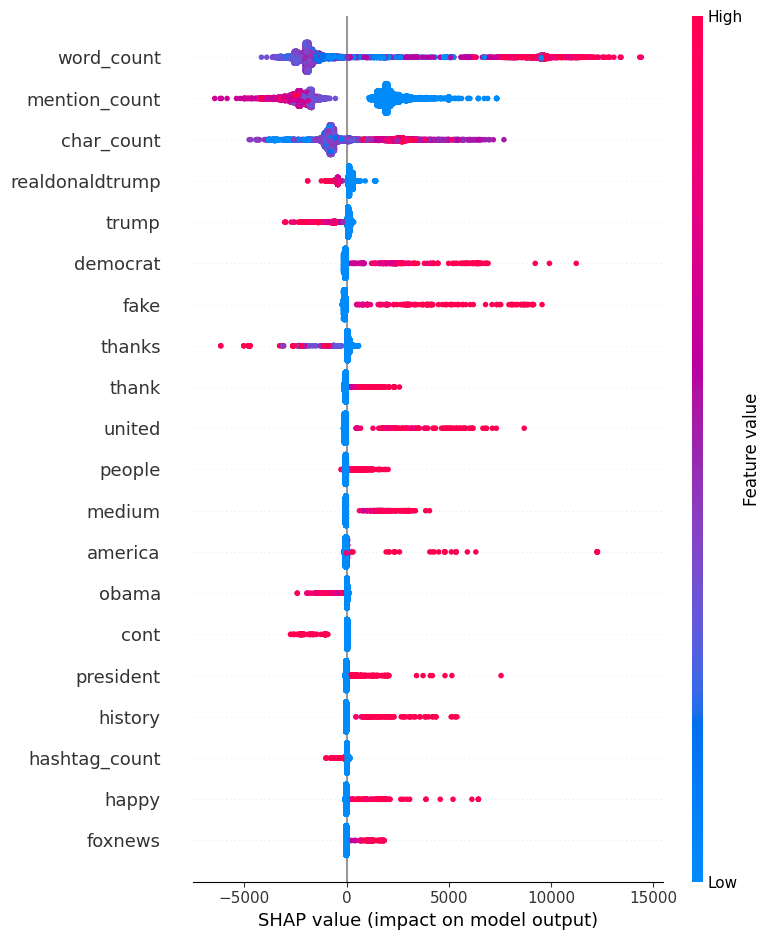

Statystyki dla tweetów zawierających 'trump':
count    14191.000000
mean      1563.698330
std       4917.802704
min          0.000000
25%         15.000000
50%         29.000000
75%        411.000000
max      95698.000000
Name: retweets, dtype: float64

Statystyki dla tweetów zawierających 'fake':
count      897.000000
mean     21419.056856
std       9752.080865
min          0.000000
25%      15611.000000
50%      19753.000000
75%      25582.000000
max      79224.000000
Name: retweets, dtype: float64


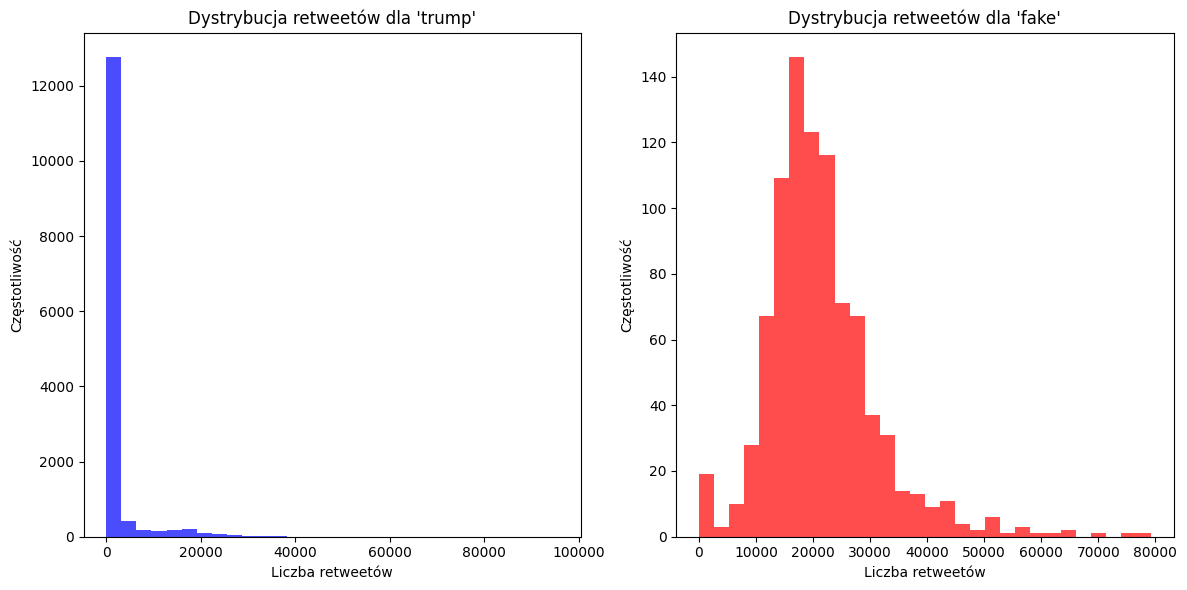

In [3]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import shap
import plotly.express as px
import matplotlib.pyplot as plt
import pickle

# Wczytaj dane
df = pd.read_csv('/content/sample_data/realdonaldtrump.csv')

# Pobierz stopwords i wordnet
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Zamiana na małe litery
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Usunięcie linków
    text = re.sub(r'[^\w\s]', '', text)  # Usunięcie znaków interpunkcyjnych
    text = re.sub(r'\d+', '', text)  # Usunięcie cyfr
    words = text.split()  # Podział na słowa
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lematyzacja i usunięcie stopwords
    return ' '.join(words)

# wstępne przetwarzanie tekstu
df['clean_text'] = df['content'].apply(preprocess_text)

# dodatkowe własności
df['char_count'] = df['content'].apply(len)  # Liczba znaków
df['word_count'] = df['content'].apply(lambda x: len(x.split()))  # Liczba słów
df['hashtag_count'] = df['hashtags'].apply(lambda x: len(x.split(",")) if isinstance(x, str) else 0)  # Liczba hashtagów
df['mention_count'] = df['mentions'].apply(lambda x: len(x.split(",")) if isinstance(x, str) else 0)  # Liczba wzmianek

# Wektoryzacja tekstu za pomocą TF-IDF
vectorizer_filename = 'tfidf_vectorizer.pkl'
with open(vectorizer_filename, 'rb') as file:
    loaded_vectorizer = pickle.load(file)

X_text = loaded_vectorizer.transform(df['clean_text']).toarray()
tfidf_feature_names = loaded_vectorizer.get_feature_names_out()

# Połączenie cech głównych z dodatkowymi
X_additional = df[['char_count', 'word_count', 'hashtag_count', 'mention_count']].values
X = np.hstack((X_text, X_additional))
all_feature_names = np.concatenate((tfidf_feature_names, ['char_count', 'word_count', 'hashtag_count', 'mention_count']))

# Definiowanie zmiennej docelowej
y = df['retweets'].values

assert X.shape[0] == y.shape[0], "Niezgodność liczby wierszy między cechami a zmienną docelową."

# Podział danych na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Wczytanie zapisanego modelu
model_filename = 'lightgbm_model.pkl'
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Przewidywanie na zbiorze testowym
y_pred = loaded_model.predict(X_test, num_iteration=loaded_model.best_iteration)

# Obliczanie MAE i R2
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Średni błąd bezwzględny (MAE): {mae}')
print(f'Współczynnik determinacji (R2): {r2}')

# Analiza SHAP
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X_test)

# Wykres podsumowujący wartości SHAP
shap.summary_plot(shap_values, X_test, feature_names=all_feature_names)

# Analiza zawartości tweetów
df['contains_trump'] = df['clean_text'].str.contains('trump')
df['contains_fake'] = df['clean_text'].str.contains('fake')

trump_stats = df[df['contains_trump']]['retweets'].describe()
fake_stats = df[df['contains_fake']]['retweets'].describe()

# Wyświetlanie statystyk
print("Statystyki dla tweetów zawierających 'trump':")
print(trump_stats)
print("\nStatystyki dla tweetów zawierających 'fake':")
print(fake_stats)

# Wykres dystrybucji retweetów dla tweetów zawierających "trump" i "fake"
plt.figure(figsize=(12, 6))

# Trump
plt.subplot(1, 2, 1)
plt.hist(df[df['contains_trump']]['retweets'], bins=30, color='blue', alpha=0.7)
plt.title("Dystrybucja retweetów dla 'trump'")
plt.xlabel('Liczba retweetów')
plt.ylabel('Częstość')

# Fake
plt.subplot(1, 2, 2)
plt.hist(df[df['contains_fake']]['retweets'], bins=30, color='red', alpha=0.7)
plt.title("Dystrybucja retweetów dla 'fake'")
plt.xlabel('Liczba retweetów')
plt.ylabel('Częstość')

plt.tight_layout()
plt.show()


# Aplikacja do testowania własnych tweetów

In [9]:
from IPython.display import display
import ipywidgets as widgets
import numpy as np
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import shap
import plotly.express as px
import pickle

# Wczytaj zapisany model i wektoryzator
model_filename = 'lightgbm_model.pkl'
vectorizer_filename = 'tfidf_vectorizer.pkl'

with open(model_filename, 'rb') as file:
    model = pickle.load(file)

with open(vectorizer_filename, 'rb') as file:
    vectorizer = pickle.load(file)

def preprocess_text(text):
    text = text.lower()  # Zamiana na małe litery
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Usunięcie linków
    text = re.sub(r'[^\w\s]', '', text)  # Usunięcie znaków interpunkcyjnych
    text = re.sub(r'\d+', '', text)  # Usunięcie cyfr
    words = text.split()  # Podział na słowa
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lematyzacja i usunięcie stopwords
    return ' '.join(words)

# Funkcja do przewidywania liczby retweetów dla podanego tweeta
def predict_retweets(tweet, hashtags='', mentions=''):
    clean_tweet = preprocess_text(tweet)
    tweet_features = vectorizer.transform([clean_tweet]).toarray()

    char_count = len(tweet)
    word_count = len(tweet.split())
    hashtag_count = len(hashtags.split()) if hashtags else 0
    mention_count = len(mentions.split()) if mentions else 0

    additional_features = np.array([[char_count, word_count, hashtag_count, mention_count]])

    tweet_data = np.hstack((tweet_features, additional_features))

    prediction = model.predict(tweet_data)
    return prediction[0]

# Tworzenie elementów interfejsu użytkownika
tweet_input = widgets.Text(
    value='WRITE your FAKE tweet!',
    placeholder='Wpisz tutaj swój tweet',
    description='Tweet:',
    disabled=False
)

hashtag_input = widgets.Text(
    value='#Trump #FakeNews',
    placeholder='Wpisz tutaj hashtagi',
    description='Hashtagi:',
    disabled=False
)

mention_input = widgets.Text(
    value='@realDonaldTrump',
    placeholder='Wpisz tutaj wzmianki',
    description='Wzmianki:',
    disabled=False
)

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        tweet = tweet_input.value
        hashtags = hashtag_input.value
        mentions = mention_input.value
        predicted_retweets = predict_retweets(tweet, hashtags, mentions)
        print(f"Przewidywana liczba retweetów: {predicted_retweets}")

predict_button = widgets.Button(
    description='Przewidź retweety',
    disabled=False,
    button_style='',
    tooltip='Kliknij, aby przewidzieć retweety',
    icon='check'
)

predict_button.on_click(on_button_clicked)

# Wyświetlanie interfejsu użytkownika
display(tweet_input, hashtag_input, mention_input, predict_button, output)


Text(value='WRITE your FAKE tweet!', description='Tweet:', placeholder='Wpisz tutaj swój tweet')

Text(value='#Trump #FakeNews', description='Hashtagi:', placeholder='Wpisz tutaj hashtagi')

Text(value='@realDonaldTrump', description='Wzmianki:', placeholder='Wpisz tutaj wzmianki')

Button(description='Przewidź retweety', icon='check', style=ButtonStyle(), tooltip='Kliknij, aby przewidzieć r…

Output()